### Install Requirement
The following python package is needed for running this code:
*   matplotlib
*   numpy
*   pandas
*   scipy
*   scikit-learn
*   pytorch

On TACC (frontera especially), the pytorch need to install from pip and need to load modules for gpu support, one tested command block to install pytorch on Frontera is:
```
module load cuda cudnn
pip install h5py
pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f
```

In [1]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
from matplotlib import pyplot as plt

# Important: Change it to TACC machine data location
data_location = "./data"

In [2]:
# define cohesive energy prediction model
class MLP_2layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super(MLP_2layer, self).__init__()
        self.input = input_dim
        self.hidden = hidden_dim
        self.output = out_dim
        self.fc1 = nn.Linear(self.input, self.hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden, self.output)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out



# define VAE model
class SimpleVAE(nn.Module):
    """
    Simple VAE
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, energy=True):
        super(SimpleVAE, self).__init__()
        self.input = input_dim
        self.hidden = hidden_dim
        self.latent = latent_dim
        self.contain_energy_prediction = energy
        self.fc1 = nn.Linear(self.input, self.hidden)
        self.dropout = nn.Dropout(p=0.25)
        self.relu1 = nn.ReLU()
        self.fc21 = nn.Linear(self.hidden, self.latent)
        self.fc22 = nn.Linear(self.hidden, self.latent)
        self.fc3 = nn.Linear(self.latent, self.hidden)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(self.hidden, self.input)
        self.energy_model = MLP_2layer(self.latent, self.latent// 2, 1)
        self.atom_type_classifier = MLP_2layer(self.latent, self.latent // 2, 7)
        self.material_prop = MLP_2layer(self.latent, self.latent // 2, 6)

    def encode(self, x):
        out = self.relu1(self.dropout(self.fc1(x)))
        return self.fc21(out), self.fc22(out)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        out = self.relu2(self.fc3(z))
        return self.fc4(out)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if self.contain_energy_prediction:
            return self.decode(z), mu, logvar, z, self.material_prop(z)
        else:
            return self.decode(z), mu, logvar, z
    
    def latent_space(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

# define auxiliary dataset class
class ndarrayDataset(Dataset):
    """simple dataset"""

    def __init__(self, X, y):
        super(ndarrayDataset, self).__init__()
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# define loss function here, the MAPE are set as criterion for cohesive energy prediction
def simplevae_elbo_loss_function_with_energy(recon_x, x, mu, logvar, pred_e, e):
    MSE = nn.MSELoss(reduction='mean')(recon_x, x)
    MAPE_eng = torch.sum(torch.abs((pred_e-e)/e))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.1 * MSE + MAPE_eng + 0.01 * KLD, MSE, MAPE_eng, KLD

def simplevae_elbo_loss_function_with_nrf(recon_x, x, mu, logvar, pred_nrf, nrf):
    MSE = nn.MSELoss(reduction='mean')(recon_x, x)
    MSE_nrf = nn.MSELoss(reduction='mean')(pred_nrf, nrf)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.1 * MSE + MSE_nrf + 0.1 * KLD, MSE, MSE_nrf, KLD

def simplevae_elbo_loss_function_with_label(recon_x, x, mu, logvar, pred_l, l):
    MSE = nn.MSELoss(reduction='mean')(recon_x, x)
    CE_eng = nn.CrossEntropyLoss(reduction='sum')(pred_l,l)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.01 * MSE + CE_eng + 0.1 * KLD, MSE, CE_eng, KLD

In [4]:
# load data (version 1)
import pickle
import os
energy = np.array(pickle.load(open(os.path.join(data_location,'energy.txt'),'rb')))
id = np.array(pickle.load(open(os.path.join(data_location,'id.txt'),'rb')))
params = np.array(pickle.load(open(os.path.join(data_location,'params.txt'),'rb')))
xrd_raw = pickle.load(open(os.path.join(data_location,'xrd.txt'),'rb'))


def load_material_data(data_location):

    data = sio.loadmat(data_location)

    input_mat = data['MP']

    # count data in different classes
    id = input_mat[:,0]
    atom_type = input_mat[:,1]
    energy = input_mat[:,2] # target value
    X = input_mat[:,3:] # training data
    return X,id,atom_type,energy

_,_,atom_type,_ = load_material_data('./data/Materials/MP_v1.mat')
print(max(atom_type))

7.0


In [5]:
n = len(xrd_raw)
print(atom_type.shape)
xrd = np.zeros((n,1000))

for i in range(n):
    xrd[i,:] = xrd_raw[i][0]

nrf = np.empty((n, 6))

for i, p in enumerate(params):
    nrf[i][0] = 1
    nrf[i][1] = (p[1]/p[0])**2
    nrf[i][2] = (p[2]/p[0])**2
    nrf[i][3] = (p[1]/p[0])*(p[2]/p[0])*np.cos(np.radians(p[3]))
    nrf[i][4] = 1*(p[2]/p[0])*np.cos(np.radians(p[4]))
    nrf[i][5] = 1*(p[1]/p[0])*np.cos(np.radians(p[5]))

# dimension mismatch
id = np.append(id,['0','0','0','0','0','0','0','0'])
atom_type = np.append(atom_type,[1,1,1,1,1,1,1,1]) - 1
X = xrd
y = nrf

print(np.max(atom_type),np.min(atom_type))

X_train, X_test, y_train, y_test, l_train, l_test, id_train, id_test = train_test_split(X, y, atom_type, id, test_size=0.20, shuffle=True, random_state=9)



(41100,)
6.0 0.0


In [9]:
# Sanity Check
import math

lattice_type_mapping={
    'triclinic': 0,
    'monoclinic': 1,
    'orthorhombic': 2,
    'tetragonal': 3,
    'rhombohedral': 3,
    'trigonal': 4,
    'hexagonal': 5,
    'cubic': 6,
    'none': -1
}

def get_symmetric_group(vec):
    a2 = vec[0]
    b2 = vec[1]
    c2 = vec[2]
    bc = vec[3]
    ac = vec[4]
    ab = vec[5]
    eps = 1e-6
    
    if a2 <= b2 <= c2:
        pass
    elif a2 <= c2 <= b2:
        b2, c2 = c2, b2
        ac, ab = ab, ac
    elif b2 <= a2 <= c2:
        a2, b2 = b2, a2
        bc, ac = ac, bc
    elif b2 <= c2 <= a2:
        a2, b2, c2 = b2, c2, a2
        bc, ac, ab = ac, ab, bc
    elif c2 <= a2 <= b2:
        a2, b2, c2 = c2, a2, b2
        bc, ac, ab = ab, bc, ac
    elif c2 <= b2 <= a2:
        a2, c2 = c2, a2
        bc, ab = ab, bc

    # a=b=c
    if abs(a2-b2) < eps and abs(b2-c2) < eps and abs(a2-c2) < eps:
        #1
        if abs(a2- 2*bc) < eps and abs(b2- 2*ac) < eps and abs(c2- 2*ab) < eps:
            return lattice_type_mapping['cubic']
        #2
        if abs(ac- bc) < eps and abs(ab- ac) < eps and abs(bc- ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #3
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['cubic']
        #4
        if abs(ac + abs(bc)) < eps and abs(ab + abs(bc)) < eps:
            return lattice_type_mapping['rhombohedral']
        #5
        if abs(a2 + 3*bc) < eps and abs(b2 + 3*ac) < eps and abs(c2 + 3*ab) < eps:
            return lattice_type_mapping['cubic']
        #6
        if abs(2 * bc + a2 - abs(ab)) < eps and abs(2 * ac + a2 - abs(ab)) < eps and ab<0.0:
            return lattice_type_mapping['tetragonal']
        #7
        if abs(2 * ac + a2 - abs(bc)) < eps and abs(2 * ab + a2 - abs(bc)) < eps and bc<0.0:
            return lattice_type_mapping['tetragonal']
        #8
        if bc < 0.0 and ac < 0.0 and abs(ab + a2 - bc - ac) < eps:
            return lattice_type_mapping['orthorhombic']
    # a=b
    elif abs(a2-b2) < eps:
        #9
        if abs(a2- 2*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #10
        if abs(ac- bc) < eps:
            return lattice_type_mapping['monoclinic']
        #11
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']
        #12
        if abs(bc) < eps and abs(ac) < eps and abs(a2 + 2 * ab) < eps:
            return lattice_type_mapping['hexagonal']    
        #13
        if abs(bc) < eps and abs(ac) < eps and ab<0:
            return lattice_type_mapping['orthorhombic']    
        #14
        if bc < 0.0 and ac < 0.0 and abs(bc-ac) < eps and ab < 0.0:
            return lattice_type_mapping['monoclinic']
        #15
        if abs(a2 + 2*bc) < eps and abs(b2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']
        #16
        if bc < 0.0 and ac < 0.0 and abs(bc-ac) < eps and abs(ab + a2 - 2 * bc) < eps:
            return lattice_type_mapping['orthorhombic']
        #17
        if bc < 0.0 and ac < 0.0 and  abs(ab + a2 - bc - ac) < eps:
            return lattice_type_mapping['monoclinic']
    # b=c
    elif abs(b2-c2) < eps:
        #18
        if abs(a2- 4*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['tetragonal']
        #19
        if abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #20
        if abs(ab - ac) < eps:
            return lattice_type_mapping['monoclinic']
        #21
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']   
        #22
        if abs(b2 + 2*bc)  < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['hexagonal']    
        #23
        if bc < 0 and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #24
        if abs(- a2 + 3* b2 + 6*bc) < eps and abs(a2 + 3*ac) < eps and abs(a2 + 3*ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #25
        if bc < 0.0 and ac < 0.0 and abs(ab-ac) < eps:
            return lattice_type_mapping['monoclinic']
    else:
        #26
        if abs(a2- 4*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['tetragonal']
        #27
        if abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #28
        if abs(ab- 2*bc) < eps and abs(a2- 2*ac) < eps:
            return lattice_type_mapping['monoclinic']
        #29
        if abs(ac- 2*bc) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #30
        if abs(b2- 2*bc) < eps and abs(ab- 2*ac) < eps:
            return lattice_type_mapping['monoclinic']
        #32
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #33
        if abs(bc) < eps and ac < 0 and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #34
        if abs(bc) < eps and abs(ac) < eps and ab < 0:
            return lattice_type_mapping['monoclinic']
        #35
        if bc < 0 and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #36
        if abs(bc) < eps and abs(a2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #37
        if bc < 0 and abs(a2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #38
        if abs(bc) < eps and abs(ac) < eps and abs(a2 + 2*ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #39
        if bc < 0 and abs(ac) < eps and abs(a2 + 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #40
        if abs(b2+ 2*bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #41
        if abs(b2+ 2*bc) < eps and ac < 0 and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #42
        if abs(b2+ 2*bc) < eps and abs(a2+ 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #43
        if abs(b2+ 2*bc -ab) < eps and abs(a2+ 2*ac -ab) < eps and ab < 0:
            return lattice_type_mapping['monoclinic']
        #44
        if bc < 0 and ac < 0 and ab < 0:
            return lattice_type_mapping['triclinic']
        #31 
        return lattice_type_mapping['triclinic']

    return lattice_type_mapping['none']

count = 0
for i in range(nrf.shape[0]):
    atom_type = get_symmetric_group(nrf[i,:])
    if atom_type==-1:
        count = count +1 
        print("Line {}, lattice parameter: {}, type: {}".format(i, nrf[i,:], atom_type))
print(count)

Line 3, lattice parameter: [ 1.          1.          0.58295769  0.0958611  -0.0958611  -0.80563223], type: -1
Line 5, lattice parameter: [ 1.          1.          1.         -0.91891993 -0.91891993  0.83783987], type: -1
Line 12, lattice parameter: [ 1.          1.          1.49409636  0.65818636 -0.65818636 -0.49816203], type: -1
Line 28, lattice parameter: [ 1.          1.          0.3773627   0.13035515 -0.13035515 -0.55227475], type: -1
Line 29, lattice parameter: [ 1.          1.          1.         -0.68025942 -0.68025942  0.36051884], type: -1
Line 43, lattice parameter: [ 1.          1.          1.         -0.67510505 -0.67510505  0.35021011], type: -1
Line 72, lattice parameter: [ 1.          1.          1.          0.28372858 -0.28372858  0.43254284], type: -1
Line 84, lattice parameter: [ 1.          1.          0.52851865  0.04889915 -0.04889915  0.34299609], type: -1
Line 91, lattice parameter: [ 1.          1.00000008  2.23983202 -0.13391689 -0.38498418 -0.48109889], typ

In [15]:

# add some parameters
class Args:
    batch_size = 256 #input batch size for training (default: 256)
    # shrink total iteration times (epochs) here to stop the program earlier
    epochs = 200 #number of epochs to train (default: 100)
    no_cuda = False
    seed = 9 # random seed (default: 9)
    log_interval = 10 # how many batches to wait before logging training status (default 10)
    gpu = 0 # gpu card id (default: 0)

args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda:%d" % args.gpu if args.cuda else "cpu")
torch.manual_seed(args.seed)



train_dataset = ndarrayDataset(X_train,l_train)
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True)
train_losses = np.zeros((args.epochs))
test_dataset = ndarrayDataset(X_test,l_test)
test_loader = DataLoader(test_dataset, batch_size=1024)
test_losses = np.zeros((args.epochs))

model = SimpleVAE(1000,256,64).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.01)


"""

Body part of train/test

"""

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        x_pred, mu, logvar, _, y_pred = model(data)
        loss, _, eng_loss, _ = simplevae_elbo_loss_function_with_label(x_pred, data, mu, logvar, y_pred, y)
        train_loss += (eng_loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t CE Loss/Total Loss: {:.6f}/{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), eng_loss.item()/ len(data),
                loss.item() / len(data)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average MAPE loss: {:.4f}'.format(epoch, train_loss))
    return train_loss


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, y) in enumerate(test_loader):
            data = data.to(device)
            y = y.long().to(device)
            x_pred, mu, logvar, _, y_pred = model(data)
            _, _, eng_loss, _,= simplevae_elbo_loss_function_with_nrf(x_pred, data, mu, logvar, y_pred, y)
            test_loss += (eng_loss.item())
            # pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # print('====> Test set acc: {:.4f}'.format(correct/len(test_loader.dataset)))
    return test_loss

train_err_list = []
test_err_list = []
for epoch in range(1, args.epochs + 1):
    train_err = train(epoch)
    test_err = test(epoch)
    train_err_list.append(train_err)
    test_err_list.append(test_err)

# The program will save the data for plotting and recovery of modeling
# This part saves the MAPE loss in each epoch
with open('MAPE_simpleVAE_class_%d.npz' % args.epochs,'wb') as f:
    np.savez(f, train_err = train_err_list, test_err = test_err_list)
torch.save(model.state_dict(),'model_simpleVAE_class_%d.pth' % args.epochs)


Train Epoch: 1 [0/32886 (0%)]	 CE Loss/Total Loss: 0.008325/0.027679
Train Epoch: 1 [2560/32886 (8%)]	 CE Loss/Total Loss: 0.007891/0.010017
Train Epoch: 1 [5120/32886 (16%)]	 CE Loss/Total Loss: 0.007691/0.008449
Train Epoch: 1 [7680/32886 (23%)]	 CE Loss/Total Loss: 0.007473/0.008064
Train Epoch: 1 [10240/32886 (31%)]	 CE Loss/Total Loss: 0.007244/0.007658
Train Epoch: 1 [12800/32886 (39%)]	 CE Loss/Total Loss: 0.007056/0.007305
Train Epoch: 1 [15360/32886 (47%)]	 CE Loss/Total Loss: 0.006988/0.007157
Train Epoch: 1 [17920/32886 (54%)]	 CE Loss/Total Loss: 0.006879/0.007202
Train Epoch: 1 [20480/32886 (62%)]	 CE Loss/Total Loss: 0.006725/0.006956
Train Epoch: 1 [23040/32886 (70%)]	 CE Loss/Total Loss: 0.006621/0.006784
Train Epoch: 1 [25600/32886 (78%)]	 CE Loss/Total Loss: 0.006417/0.006506
Train Epoch: 1 [28160/32886 (85%)]	 CE Loss/Total Loss: 0.006597/0.006701
Train Epoch: 1 [30720/32886 (93%)]	 CE Loss/Total Loss: 0.006419/0.006598
====> Epoch: 1 Average MAPE loss: 0.0071
====> 

Train acc: 0.5006
Test acc: 0.5023


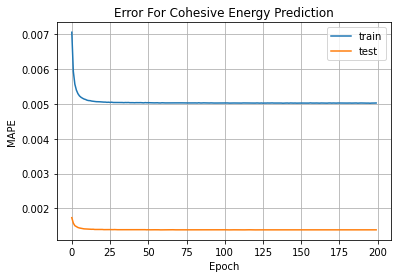

<Figure size 432x288 with 0 Axes>

In [23]:
# Evaluation part
import pandas as pd

# Uncomment these two lines to load a past trained network
# otherwise the model in the last block will be used

model.load_state_dict(torch.load('model_simpleVAE_class_200.pth'))
model.to(device)




# Check last epoch's mape for each individual data and record in csv files
rowlist = []
correct = 0
for batch_idx, (data, y) in enumerate(train_dataset):
    data = data.to(device)
    y = y.long().to(device)
    #y_pred = model(data)
    _,_,_,_,y_pred = model(data)
    pred = y_pred.argmax(dim=0, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(y.view_as(pred)).sum().item()

print("Train acc: {:.4f}".format(correct/len(train_dataset)))

mapes = 0
max_mapes = 0
rowlist = []
correct = 0
for batch_idx, (data, y) in enumerate(test_dataset):
    data = data.to(device)
    y = y.long().to(device)
    #y_pred = model(data)
    _,_,_,_,y_pred = model(data)
    pred = y_pred.argmax(dim=0, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(y.view_as(pred)).sum().item()

print("Test acc: {:.4f}".format(correct/len(test_dataset)))
# Uncomment these lines if you wish to plot the past record

with open('MAPE_simpleVAE_class_200.npz','rb') as f:
    data = np.load(f)
    train_err_list = data['train_err']
    test_err_list = data['test_err']

# plot average MAPE over all iterations
plt.title("Error For Cohesive Energy Prediction")
plt.plot(train_err_list, label='train')
plt.plot(test_err_list, label='test')
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.grid()
plt.legend()
plt.show()
plt.savefig('simpleVAE_mape.png') # can be saved as .svg file
